# Baseball Analytics  : Sci-kit Learn

## A scikit-learn tutorial to predicting MLB wins per season by modeling data to KMeans clustering model and linear regression models.



### Part 1 : Predicting MLB Team Wins per Season


#### Importing Data
#### In this tutorial, you’ll see how you can easily load in data from a database with sqlite3, how you can explore your data and improve its data quality with pandas and matplotlib, and how you can then use the Scikit-Learn package to extract some valid insights out of your data.
#### You will read in the data by querying a sqlite database using the sqlite3 package and converting to a DataFrame with pandas. Your data will be filtered to only include currently active modern teams and only years where the team played 150 or more games.

In [1]:
# importing pandas and sqlite3 packages
import pandas as pd
import sqlite3


In [2]:
#connecting the sqlite database to the notebook
conn = sqlite3.connect("lahman2016.sqlite")

In [3]:
#Writing the sql query to select the teams which have played more than 150 games and are still active
query = '''select * from Teams
inner join TeamsFranchises on Teams.franchID == TeamsFranchises.franchID
where Teams.G >= 150 and TeamsFranchises.active== 'Y';  '''


#Executing the query 
Teams = conn.execute(query).fetchall()

In [4]:
# Converting the result to dataframe 
df_Teams = pd.DataFrame(Teams)
df_Teams.head()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,1961,AL,LAA,ANA,None,8,162,82.0,70,91,...,603510,111,112,LAA,LAA,LAA,ANA,Los Angeles Angels of Anaheim,Y,None
1,1962,AL,LAA,ANA,None,3,162,81.0,86,76,...,1144063,97,97,LAA,LAA,LAA,ANA,Los Angeles Angels of Anaheim,Y,None
2,1963,AL,LAA,ANA,None,9,161,81.0,70,91,...,821015,94,94,LAA,LAA,LAA,ANA,Los Angeles Angels of Anaheim,Y,None
3,1964,AL,LAA,ANA,None,5,162,81.0,82,80,...,760439,90,90,LAA,LAA,LAA,ANA,Los Angeles Angels of Anaheim,Y,None
4,1965,AL,CAL,ANA,None,7,162,80.0,75,87,...,566727,97,98,CAL,CAL,CAL,ANA,Los Angeles Angels of Anaheim,Y,None


#### Cleaning and Preparing The Data

#### Prior to assessing the data quality, let’s first eliminate the columns that aren’t necessary or are derived from the target column (Wins). This is where knowledge of the data you are working with starts to become very valuable.

In [5]:
# Adding column names to dataframe
cols = ['yearID','lgID','teamID','franchID','divID','Rank','G','Ghome','W','L','DivWin','WCWin','LgWin','WSWin','R','AB','H','2B','3B','HR','BB','SO','SB','CS','HBP','SF','RA','ER','ERA','CG','SHO','SV','IPouts','HA','HRA','BBA','SOA','E','DP','FP','name','park','attendance','BPF','PPF','teamIDBR','teamIDlahman45','teamIDretro','franchID','franchName','active','NAassoc']

df_Teams.columns = cols

df_Teams.head()

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro,franchID,franchName,active,NAassoc
0,1961,AL,LAA,ANA,None,8,162,82.0,70,91,...,603510,111,112,LAA,LAA,LAA,ANA,Los Angeles Angels of Anaheim,Y,None
1,1962,AL,LAA,ANA,None,3,162,81.0,86,76,...,1144063,97,97,LAA,LAA,LAA,ANA,Los Angeles Angels of Anaheim,Y,None
2,1963,AL,LAA,ANA,None,9,161,81.0,70,91,...,821015,94,94,LAA,LAA,LAA,ANA,Los Angeles Angels of Anaheim,Y,None
3,1964,AL,LAA,ANA,None,5,162,81.0,82,80,...,760439,90,90,LAA,LAA,LAA,ANA,Los Angeles Angels of Anaheim,Y,None
4,1965,AL,CAL,ANA,None,7,162,80.0,75,87,...,566727,97,98,CAL,CAL,CAL,ANA,Los Angeles Angels of Anaheim,Y,None


In [6]:
# Dropping your unnecesary column variables.
drop_cols = ['lgID','franchID','divID','Rank','Ghome','L','DivWin','WCWin','LgWin','WSWin','SF','name','park','attendance','BPF','PPF','teamIDBR','teamIDlahman45','teamIDretro','franchID','franchName','active','NAassoc']

df = df_Teams.drop(drop_cols, axis=1)

df.head()

,yearID,teamID,G,W,R,AB,H,2B,3B,HR,...,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP
0,1961,LAA,162,70,744,5424,1331,218,22,189,...,5,34,4314,1391,180,713,973,192,154.0,0.969
1,1962,LAA,162,86,718,5499,1377,232,35,137,...,15,47,4398,1412,118,616,858,175,153.0,0.972
2,1963,LAA,161,70,597,5506,1378,208,38,95,...,13,31,4365,1317,120,578,889,163,155.0,0.974
3,1964,LAA,162,82,544,5362,1297,186,27,102,...,28,41,4350,1273,100,530,965,138,168.0,0.978
4,1965,CAL,162,75,527,5354,1279,200,36,92,...,14,33,4323,1259,91,563,847,123,149.0,0.981


#### Handling Missing Values
#### Two of the columns have a relatively small amount of null values. There are 110 null values in the SO (Strike Outs) column and 22 in the DP (Double Play) column. Two of the columns have a relatively large amount of them. There are 419 null values in the CS (Caught Stealing) column and 1777 in the HBP (Hit by Pitch) column.

In [7]:
#Identifying the number of null values in the dataframe
# Creating a for loop to display the column names and also their count of missing values 

names= [] # Empty list
val = [] # Empty list 
for col in df.columns:
    names.append(col) # Adding the column name to the names list
    val.append(df[col].isnull().sum())  # Adding the count of the missing values 
    print(col, val[-1]) # Printing the column names and thier missing counts ie : 2 lists 



yearID 0
teamID 0
G 0
W 0
R 0
AB 0
H 0
2B 0
3B 0
HR 0
BB 0
SO 110
SB 0
CS 419
HBP 1777
RA 0
ER 0
ERA 0
CG 0
SHO 0
SV 0
IPouts 0
HA 0
HRA 0
BBA 0
SOA 0
E 0
DP 22
FP 0


In [8]:
#Dropping the columns with large number of null values

df = df.drop(['CS','HBP'], axis=1)

df.head()

,yearID,teamID,G,W,R,AB,H,2B,3B,HR,...,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP
0,1961,LAA,162,70,744,5424,1331,218,22,189,...,5,34,4314,1391,180,713,973,192,154.0,0.969
1,1962,LAA,162,86,718,5499,1377,232,35,137,...,15,47,4398,1412,118,616,858,175,153.0,0.972
2,1963,LAA,161,70,597,5506,1378,208,38,95,...,13,31,4365,1317,120,578,889,163,155.0,0.974
3,1964,LAA,162,82,544,5362,1297,186,27,102,...,28,41,4350,1273,100,530,965,138,168.0,0.978
4,1965,CAL,162,75,527,5354,1279,200,36,92,...,14,33,4323,1259,91,563,847,123,149.0,0.981


#### Imputing missing values 

In [9]:
# Filling the missing values with the median of their respective column values

## Median  because they are using integers  ** Data type **
df['SO'] = df['SO'].fillna(df['SO'].median())
df['DP'] = df['DP'].fillna(df['DP'].median())

df.head()

,yearID,teamID,G,W,R,AB,H,2B,3B,HR,...,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP
0,1961,LAA,162,70,744,5424,1331,218,22,189,...,5,34,4314,1391,180,713,973,192,154.0,0.969
1,1962,LAA,162,86,718,5499,1377,232,35,137,...,15,47,4398,1412,118,616,858,175,153.0,0.972
2,1963,LAA,161,70,597,5506,1378,208,38,95,...,13,31,4365,1317,120,578,889,163,155.0,0.974
3,1964,LAA,162,82,544,5362,1297,186,27,102,...,28,41,4350,1273,100,530,965,138,168.0,0.978
4,1965,CAL,162,75,527,5354,1279,200,36,92,...,14,33,4323,1259,91,563,847,123,149.0,0.981


In [10]:
#Again checking for null values 
print(df.isnull().sum(axis=0).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Exploring and Visualizing The Data
#### You’ll start by plotting a histogram of the target column so you can see the distribution of wins

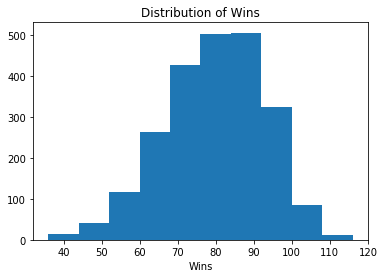

In [11]:
#importing matplotlib

import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(df['W'])
plt.xlabel('Wins')
plt.title('Distribution of Wins')
plt.show()

In [12]:
print(df['W'].mean())

79.23043288150416


#### It can be useful to create bins for your target column while exploring your data, but you need to make sure not to include any feature that you generate from your target column when you train the model. Including a column of labels generated from the target column in your training set would be like giving your model the answers to the test.

In [13]:
#Creating Bins for ploting and understanding of the target 

## Binning for Cintinuous and categorical 

def assign_win_bins(W):
    if W < 50:                    # Creating a bin value of 1 for wins amounting less than 50
        return 1
    if W >= 50 and W <= 69:       # Creating a bin value of 1 for wins amounting less than 70 and greater than 50 
        return 2
    if W >= 70 and W <= 89:       # Creating a bin value of 1 for wins amounting less than 90 and greater than 70
        return 3
    if W >= 90 and W <= 109:      # Creating a bin value of 1 for wins amounting less than 110 and greater than 90
        return 4
    if W >= 110:                  # Creating a bin value of 1 for wins amounting greater than 110
        return 5
   
df['Win_bins'] = df['W'].apply(assign_win_bins)  # Creating a new column Win_bins in the dataframe

df.head()

,yearID,teamID,G,W,R,AB,H,2B,3B,HR,...,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,Win_bins
0,1961,LAA,162,70,744,5424,1331,218,22,189,...,34,4314,1391,180,713,973,192,154.0,0.969,3
1,1962,LAA,162,86,718,5499,1377,232,35,137,...,47,4398,1412,118,616,858,175,153.0,0.972,3
2,1963,LAA,161,70,597,5506,1378,208,38,95,...,31,4365,1317,120,578,889,163,155.0,0.974,3
3,1964,LAA,162,82,544,5362,1297,186,27,102,...,41,4350,1273,100,530,965,138,168.0,0.978,3
4,1965,CAL,162,75,527,5354,1279,200,36,92,...,33,4323,1259,91,563,847,123,149.0,0.981,3


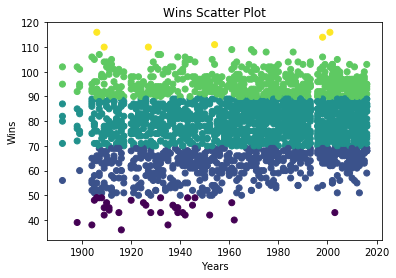

In [14]:
#Scatter plot for the yearwise wins

plt.scatter(df['yearID'],df['W'], c=df['Win_bins'])
plt.title("Wins Scatter Plot")
plt.xlabel("Years")
plt.ylabel("Wins")
plt.show()

#### Anyone who follows the game of baseball knows that, as Major League Baseball (MLB) progressed, different eras emerged where the amount of runs per game increased or decreased significantly. The dead ball era of the early 1900s is an example of a low scoring era and the steroid era at the turn of the 21st century is an example of a high scoring era.

In [15]:
#Filtering the years before year 1900

df= df[df['yearID'] > 1900]


#### Creating dictionaries runs_per_year and games_per_year. Loop through the dataframe using the iterrows() method. Populate the runs_per_year dictionary with years as keys and how many runs were scored that year as the value. Populate the games_per_year dictionary with years as keys and how many games were played that year as the value.

In [16]:
runs_per_year = df.groupby('yearID')['R'].sum()
games_per_year = df.groupby('yearID')['G'].sum()
#mlb_per_year = df.groupby('yearID')['R''G'].sum()
#mlb_per_year
RG = pd.concat([runs_per_year,games_per_year],axis=1)
RG['mlb'] = RG['R']/RG['G']
RG

,R,G,mlb
yearID,,,
1904,9307,2498,3.725781
1905,9640,2474,3.896524
1906,8322,2307,3.607282
1907,8186,2317,3.533017
1908,8423,2488,3.385450
1909,8805,2482,3.547542
1910,9580,2498,3.835068
1911,11164,2474,4.512530
1912,11154,2464,4.526786


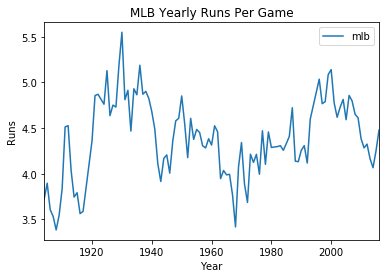

In [17]:
RG.plot(y='mlb',use_index="True")
plt.title("MLB Yearly Runs Per Game")
plt.xlabel("Year")
plt.ylabel("Runs")
plt.show()

In [18]:
# Creating the runs per yearand games per year 

## Use Goupby and sum the count yearly
# DF.groupby("YearID").sum()

#runs_per_year = {}
#games_per_year = {}

#for i, row in df.iterrows():
 #   year=row['yearID']
 #   runs=row['R']
  #  games=row['G']
   # if year in runs_per_year:
    #    runs_per_year[year]=runs_per_year[year]+ runs
     #   games_per_year[year]=games_per_year[year]+ games
    #else:
     #   runs_per_year[year]=runs
      #  games_per_year[year]=games
        
## ADD notes to the print statement         
#print('Runs_per_year', runs_per_year)
#print(' Games_per_year', games_per_year)

In [25]:
# mlb runs per game (per year) dictionary 
mlb_runs_per_game = {}
for k,v in games_per_year.items():
    year = k 
    games = v
    runs = runs_per_year[year]
    mlb_runs_per_game[year]= runs/games
    
print(mlb_runs_per_game)    
    

{1904: 3.7257806244995995, 1905: 3.896523848019402, 1906: 3.6072821846553964, 1907: 3.5330168321104876, 1908: 3.385450160771704, 1909: 3.5475423045930703, 1910: 3.8350680544435547, 1911: 4.5125303152789007, 1912: 4.5267857142857144, 1913: 4.0372771474878446, 1914: 3.7452229299363058, 1915: 3.7927710843373492, 1916: 3.5641539695268647, 1917: 3.5878107457898958, 1920: 4.3606158833063207, 1921: 4.855573637103336, 1922: 4.8703554119547654, 1923: 4.8150851581508514, 1924: 4.7611697806661253, 1925: 5.1286644951140063, 1926: 4.6365478119935171, 1927: 4.7512135922330101, 1928: 4.7298943948009748, 1929: 5.1859235150528882, 1930: 5.5490275526742305, 1931: 4.8106796116504853, 1932: 4.9132197891321976, 1933: 4.4672166739036037, 1934: 4.9303439268611235, 1935: 4.86468952734013, 1936: 5.1882067851373179, 1937: 4.8708635996771594, 1938: 4.9020461471484547, 1939: 4.8237205523964253, 1940: 4.6796116504854366, 1941: 4.4887459807073951, 1942: 4.111739130434783, 1943: 3.9151857835218093, 1944: 4.167874396

In [26]:
#Creating lists from mlb_runs_per_game
## List of tuples ( x, y ) need to be explained 
#lists = sorted(mlb_runs_per_game.items())
#x,y = zip(*lists)

#plt.plot(x,y)
#plt.title("MLB Yearly Runs Per Game")
#plt.xlabel("Year")
#plt.ylabel("Runs")
#plt.show()

In [27]:
### DELETE
#df.head()

In [28]:
# Creating "year_label" column, which will give your algorithm information about how certain years are related 
# (Dead ball eras, Live ball/Steroid Eras)
# Function calls

def assign_label(year):
    if year < 1920:
        return 1
    elif year >= 1920 and year <= 1941:
        return 2
    elif year >= 1942 and year <= 1945:
        return 3
    elif year >= 1946 and year <= 1962:
        return 4
    elif year >= 1963 and year <= 1976:
        return 5
    elif year >= 1977 and year <= 1992:
        return 6
    elif year >= 1993 and year <= 2009:
        return 7
    elif year >= 2010:
        return 8
        
# Add `year_label` column to `df`    
df['year_label'] = df['yearID'].apply(assign_label)

dummy_df = pd.get_dummies(df['year_label'], prefix='era')

# Concatenate `df` and `dummy_df`
df = pd.concat([df, dummy_df], axis=1)

df.head()

,yearID,teamID,G,W,R,AB,H,2B,3B,HR,...,era_7,era_8,era_1,era_2,era_3,era_4,era_5,era_6,era_7,era_8
0,1961,LAA,162,70,744,5424,1331,218,22,189,...,0,0,0,0,0,1,0,0,0,0
1,1962,LAA,162,86,718,5499,1377,232,35,137,...,0,0,0,0,0,1,0,0,0,0
2,1963,LAA,161,70,597,5506,1378,208,38,95,...,0,0,0,0,0,0,1,0,0,0
3,1964,LAA,162,82,544,5362,1297,186,27,102,...,0,0,0,0,0,0,1,0,0,0
4,1965,CAL,162,75,527,5354,1279,200,36,92,...,0,0,0,0,0,0,1,0,0,0


In [29]:
# Create column for MLB runs per game from the mlb_runs_per_game dictionary
def assign_mlb_rpg(year):
    return mlb_runs_per_game[year]

df['mlb_rpg'] = df['yearID'].apply(assign_mlb_rpg)

In [30]:
### DELETE
#df['mlb_rpg'][:5]

In [31]:
# Convert years into decade bins and creating dummy variables
def assign_decade(year):
    if year < 1920:
        return 1910
    elif year >= 1920 and year <= 1929:
        return 1920
    elif year >= 1930 and year <= 1939:
        return 1930
    elif year >= 1940 and year <= 1949:
        return 1940
    elif year >= 1950 and year <= 1959:
        return 1950
    elif year >= 1960 and year <= 1969:
        return 1960
    elif year >= 1970 and year <= 1979:
        return 1970
    elif year >= 1980 and year <= 1989:
        return 1980
    elif year >= 1990 and year <= 1999:
        return 1990
    elif year >= 2000 and year <= 2009:
        return 2000
    elif year >= 2010:
        return 2010
    
df['decade_label'] = df['yearID'].apply(assign_decade)
decade_df = pd.get_dummies(df['decade_label'], prefix='decade')
df = pd.concat([df, decade_df], axis=1)

# Drop unnecessary columns
df = df.drop(['yearID','year_label','decade_label'], axis=1)

In [32]:
# Create new features for Runs per Game and Runs Allowed per Game
df['R_per_game'] = df['R'] / df['G']
df['RA_per_game'] = df['RA'] / df['G']
df

,teamID,G,W,R,AB,H,2B,3B,HR,BB,...,decade_1940,decade_1950,decade_1960,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010,R_per_game,RA_per_game
0,LAA,162,70,744,5424,1331,218,22,189,681,...,0,0,1,0,0,0,0,0,4.592593,4.839506
1,LAA,162,86,718,5499,1377,232,35,137,602,...,0,0,1,0,0,0,0,0,4.432099,4.358025
2,LAA,161,70,597,5506,1378,208,38,95,448,...,0,0,1,0,0,0,0,0,3.708075,4.099379
3,LAA,162,82,544,5362,1297,186,27,102,472,...,0,0,1,0,0,0,0,0,3.358025,3.401235
4,CAL,162,75,527,5354,1279,200,36,92,443,...,0,0,1,0,0,0,0,0,3.253086,3.512346
5,CAL,162,80,604,5360,1244,179,54,122,525,...,0,0,1,0,0,0,0,0,3.728395,3.969136
6,CAL,161,84,567,5307,1265,170,37,114,453,...,0,0,1,0,0,0,0,0,3.521739,3.645963
7,CAL,162,67,498,5331,1209,170,33,83,447,...,0,0,1,0,0,0,0,0,3.074074,3.796296
8,CAL,163,71,528,5316,1221,151,29,88,516,...,0,0,1,0,0,0,0,0,3.239264,4.000000
9,CAL,162,86,631,5532,1391,197,40,114,447,...,0,0,0,1,0,0,0,0,3.895062,3.888889


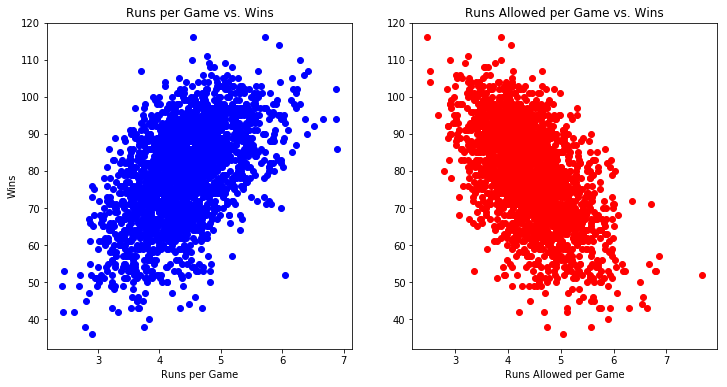

In [33]:
# Create scatter plots for runs per game vs. wins and runs allowed per game vs. wins
import numpy as np
## Try Adding trendline 
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.scatter(df['R_per_game'], df['W'], c='blue')
ax1.set_title('Runs per Game vs. Wins')
ax1.set_ylabel('Wins')
ax1.set_xlabel('Runs per Game')

#z = np.polyfit(x, y, 1)
#p = np.poly1d(z)
#plt.plot(x,p(x),"r--")


ax2.scatter(df['RA_per_game'], df['W'], c='red')
ax2.set_title('Runs Allowed per Game vs. Wins')
ax2.set_xlabel('Runs Allowed per Game')

#z = np.polyfit(x, y, 1)
#p = np.poly1d(z)
#plt.plot(x,p(x),"r--")


plt.show()

### To see how each of the variables is correlated with the target variable. Pandas makes this easy with the corr() method.

In [34]:
# Check the correlation of the variables with the target variable
df.corr()['W'] > 0.5 

G              False
W               True
R               True
AB             False
H              False
2B             False
3B             False
HR             False
BB             False
SO             False
SB             False
RA             False
ER             False
ERA            False
CG             False
SHO            False
SV             False
IPouts         False
HA             False
HRA            False
BBA            False
SOA            False
E              False
DP             False
FP             False
Win_bins        True
era_1          False
era_2          False
era_3          False
era_4          False
era_5          False
era_6          False
era_7          False
era_8          False
era_1          False
era_2          False
era_3          False
era_4          False
era_5          False
era_6          False
era_7          False
era_8          False
mlb_rpg        False
decade_1910    False
decade_1920    False
decade_1930    False
decade_1940    False
decade_1950  

In [35]:
(df.corr()['W'] < -0.5) | (df.corr()['W'] > 0.5) 

G              False
W               True
R               True
AB             False
H              False
2B             False
3B             False
HR             False
BB             False
SO             False
SB             False
RA              True
ER             False
ERA            False
CG             False
SHO            False
SV             False
IPouts         False
HA             False
HRA            False
BBA            False
SOA            False
E              False
DP             False
FP             False
Win_bins        True
era_1          False
era_2          False
era_3          False
era_4          False
era_5          False
era_6          False
era_7          False
era_8          False
era_1          False
era_2          False
era_3          False
era_4          False
era_5          False
era_6          False
era_7          False
era_8          False
mlb_rpg        False
decade_1910    False
decade_1920    False
decade_1930    False
decade_1940    False
decade_1950  

In [36]:
s1 = df.corr()['W'] > 0.5 
s2 = df.corr()['W'] < -0.5
s1 | s2 # logical OR

G              False
W               True
R               True
AB             False
H              False
2B             False
3B             False
HR             False
BB             False
SO             False
SB             False
RA              True
ER             False
ERA            False
CG             False
SHO            False
SV             False
IPouts         False
HA             False
HRA            False
BBA            False
SOA            False
E              False
DP             False
FP             False
Win_bins        True
era_1          False
era_2          False
era_3          False
era_4          False
era_5          False
era_6          False
era_7          False
era_8          False
era_1          False
era_2          False
era_3          False
era_4          False
era_5          False
era_6          False
era_7          False
era_8          False
mlb_rpg        False
decade_1910    False
decade_1920    False
decade_1930    False
decade_1940    False
decade_1950  

In [37]:
#Creating a new dataframe excluding the target variable 

attributes = ['G','R','AB','H','2B','3B','HR','BB','SO','SB','RA','ER','ERA','CG',
'SHO','SV','IPouts','HA','HRA','BBA','SOA','E','DP','FP','decade_1910','decade_1920','decade_1930','decade_1940','decade_1950','decade_1960','decade_1970','decade_1980','decade_1990','decade_2000','decade_2010','R_per_game','RA_per_game','mlb_rpg']

data_attributes = df[attributes]
#ata_attributes = df.drop(['W', 'winbins'], axis=1)

# Print the first rows of `df`
#print(df.head())
#data_attributes

set(df.columns) - set(data_attributes.columns)

{'W',
 'Win_bins',
 'era_1',
 'era_2',
 'era_3',
 'era_4',
 'era_5',
 'era_6',
 'era_7',
 'era_8',
 'teamID'}

### K Means Model : Euclidian distance 

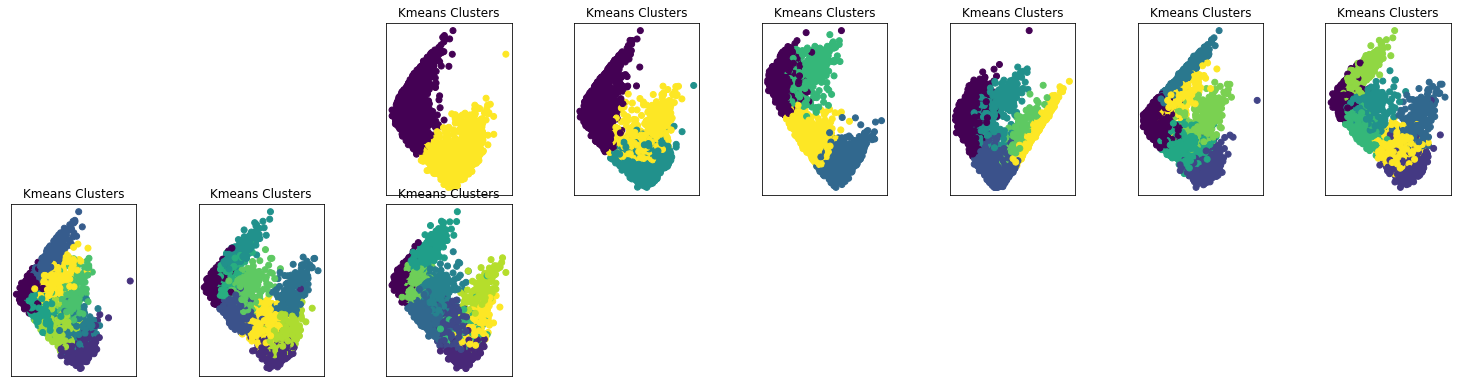

{2: [0.39070077846349777], 3: [0.33807657841298644], 4: [0.25351965230440965], 5: [0.23561599385994952], 6: [0.21388674074180872], 7: [0.19570332335360252], 8: [0.1866086242802163], 9: [0.1735452737206501], 10: [0.16986436819982936]}


In [57]:
# K-Means Clustering 
#importing sklearn

from sklearn.cluster import KMeans
from sklearn import metrics


fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace=0.05,wspace=0.5)
#Create silhoutte score dictionary 
s_score_dict = {}
for i in range(2,11):
    ax=fig.add_subplot(8,8,i+1,xticks=[],yticks=[])
    km = KMeans(n_clusters=i, random_state=1)
    distances = km.fit_transform(data_attributes)
    labels = km.labels_
    l= km.fit_predict(data_attributes)
    s_s= metrics.silhouette_score(data_attributes,l)
    s_score_dict[i] = [s_s]
    plt.scatter(distances[:,0], distances[:,1], c=labels)
    plt.title('Kmeans Clusters')

plt.show()
    
    
print(s_score_dict)    

#### K Means : Scatter

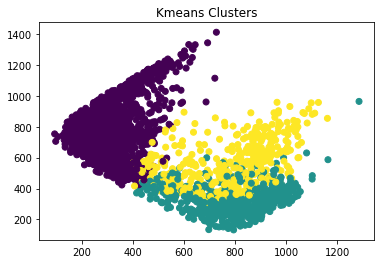

In [56]:
# Create K-means model and determine euclidian distances for each data point

# Best performance use k = 3 

kmeans_model = KMeans(n_clusters=3, random_state=1)
distances = kmeans_model.fit_transform(data_attributes)

# Create scatter plot using labels from K-means model as color
labels = kmeans_model.labels_

plt.scatter(distances[:,0], distances[:,1], c=labels)
plt.title('Kmeans Clusters')

plt.show()

In [60]:
# Add labels from K-means model to `df` DataFrame and attributes list
df['labels'] = labels
attributes.append('labels')

# Print the first rows of `df`



df.head()

,teamID,G,W,R,AB,H,2B,3B,HR,BB,...,decade_1950,decade_1960,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010,R_per_game,RA_per_game,labels
0,LAA,162,70,744,5424,1331,218,22,189,681,...,0,1,0,0,0,0,0,4.592593,4.839506,7
1,LAA,162,86,718,5499,1377,232,35,137,602,...,0,1,0,0,0,0,0,4.432099,4.358025,3
2,LAA,161,70,597,5506,1378,208,38,95,448,...,0,1,0,0,0,0,0,3.708075,4.099379,4
3,LAA,162,82,544,5362,1297,186,27,102,472,...,0,1,0,0,0,0,0,3.358025,3.401235,4
4,CAL,162,75,527,5354,1279,200,36,92,443,...,0,1,0,0,0,0,0,3.253086,3.512346,4


In [61]:
# Setting the labels column to the beginning of the dataframe.

df.set_index('labels').reset_index() #( Using the set and reindex option )

#cols = list(df.columns)
#cols = cols[-1] + cols[:-1]
#reset colunmns of df to cols - df.columns

,labels,teamID,G,W,R,AB,H,2B,3B,HR,...,decade_1940,decade_1950,decade_1960,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010,R_per_game,RA_per_game
0,7,LAA,162,70,744,5424,1331,218,22,189,...,0,0,1,0,0,0,0,0,4.592593,4.839506
1,3,LAA,162,86,718,5499,1377,232,35,137,...,0,0,1,0,0,0,0,0,4.432099,4.358025
2,4,LAA,161,70,597,5506,1378,208,38,95,...,0,0,1,0,0,0,0,0,3.708075,4.099379
3,4,LAA,162,82,544,5362,1297,186,27,102,...,0,0,1,0,0,0,0,0,3.358025,3.401235
4,4,CAL,162,75,527,5354,1279,200,36,92,...,0,0,1,0,0,0,0,0,3.253086,3.512346
5,4,CAL,162,80,604,5360,1244,179,54,122,...,0,0,1,0,0,0,0,0,3.728395,3.969136
6,4,CAL,161,84,567,5307,1265,170,37,114,...,0,0,1,0,0,0,0,0,3.521739,3.645963
7,4,CAL,162,67,498,5331,1209,170,33,83,...,0,0,1,0,0,0,0,0,3.074074,3.796296
8,4,CAL,163,71,528,5316,1221,151,29,88,...,0,0,1,0,0,0,0,0,3.239264,4.000000
9,4,CAL,162,86,631,5532,1391,197,40,114,...,0,0,0,1,0,0,0,0,3.895062,3.888889


In [62]:

from numpy import number
my_data = df.select_dtypes(include=['number'])
my_data.columns


Index(['G', 'W', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'RA',
       'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA',
       'E', 'DP', 'FP', 'Win_bins', 'era_1', 'era_2', 'era_3', 'era_4',
       'era_5', 'era_6', 'era_7', 'era_8', 'era_1', 'era_2', 'era_3', 'era_4',
       'era_5', 'era_6', 'era_7', 'era_8', 'mlb_rpg', 'decade_1910',
       'decade_1920', 'decade_1930', 'decade_1940', 'decade_1950',
       'decade_1960', 'decade_1970', 'decade_1980', 'decade_1990',
       'decade_2000', 'decade_2010', 'R_per_game', 'RA_per_game', 'labels'],
      dtype='object')

In [63]:
#set(my_data.columns) == set(numeric_cols)

In [64]:
len(my_data.columns)

57

In [65]:
#len(numeric_cols)

### Splitting your data into train and test sets

In [66]:
# Create new DataFrame using only variables to be included in models
numeric_cols = ['G','R','AB','H','2B','3B','HR','BB','SO','SB','RA','ER','ERA','CG','SHO','SV','IPouts',
                'HA','HRA','BBA','SOA','E','DP','FP','decade_1910','decade_1920','decade_1930','decade_1940',
                'decade_1950','decade_1960','decade_1970','decade_1980','decade_1990','decade_2000','decade_2010',
                'R_per_game','RA_per_game','mlb_rpg','labels','W']

#from numpy import number
#my_data = df.select_dtypes(include=['number'])
#my_data.columns

data = df[numeric_cols]
print(data.head())

# Split data DataFrame into train and test sets
train = data.sample(frac=0.75, random_state=1)
test = data.loc[~data.index.isin(train.index)]

x_train = train[attributes]
y_train = train['W']
x_test = test[attributes]
y_test = test['W']



     G    R    AB     H   2B  3B   HR   BB      SO   SB ...  decade_1970  \
0  162  744  5424  1331  218  22  189  681  1068.0   37 ...            0   
1  162  718  5499  1377  232  35  137  602   917.0   46 ...            0   
2  161  597  5506  1378  208  38   95  448   916.0   43 ...            0   
3  162  544  5362  1297  186  27  102  472   920.0   49 ...            0   
4  162  527  5354  1279  200  36   92  443   973.0  107 ...            0   

   decade_1980  decade_1990  decade_2000  decade_2010  R_per_game  \
0            0            0            0            0    4.592593   
1            0            0            0            0    4.432099   
2            0            0            0            0    3.708075   
3            0            0            0            0    3.358025   
4            0            0            0            0    3.253086   

   RA_per_game   mlb_rpg  labels   W  
0     4.839506  4.525175       7  70  
1     4.358025  4.460518       3  86  
2     4.099

### Selecting Error Metric and Model


In [67]:
# Import `LinearRegression` from `sklearn.linear_model`
from sklearn.linear_model import LinearRegression

# Import `mean_absolute_error` from `sklearn.metrics`
from sklearn.metrics import mean_absolute_error

# Create Linear Regression model, fit model, and make predictions
lr = LinearRegression(normalize=True)
lr.fit(x_train, y_train)
predictions = lr.predict(x_test)

x_train
# Determine mean absolute error
mae = mean_absolute_error(y_test, predictions)

# Print `mae`
print(mae)

2.68790254881


In [77]:
#  *** Printing the model ****

#print(predictions)
#lr.coef_
#lr.intercept_

array([ -9.02661818e-01,   9.14877928e-02,  -3.49355174e-02,
         3.01417117e-02,   4.94464163e-04,   3.37139277e-03,
         8.09249275e-03,  -4.29196177e-03,  -1.51692194e-04,
        -5.34250275e-03,   1.26836862e-01,  -1.69972356e-01,
         2.64487789e+01,   1.17775637e-01,   1.57705951e-01,
         3.16000917e-01,   7.32837197e-02,  -5.10898363e-03,
        -1.10289413e-02,  -5.97909407e-03,   7.54636289e-04,
        -6.63464503e-02,   4.38556390e-03,  -3.30769278e+02,
        -2.49571609e+00,  -1.80754591e+00,   1.74499233e+00,
         2.18052182e+00,   2.35933902e-01,   3.15784553e-01,
         2.97327047e-01,  -2.12864060e-01,  -6.93290261e-01,
         3.39921919e-01,   1.05240760e+00,  -1.15820443e+00,
        -2.92926198e+01,   3.41787374e-01,   2.77279889e-03,
         2.77279889e-03,   2.77279889e-03])

In [78]:
# Import `RidgeCV` from `sklearn.linear_model`
from sklearn.linear_model import RidgeCV

# Create Ridge Linear Regression model, fit model, and make predictions
rrm = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0), normalize=True)
rrm.fit(x_train, y_train)
predictions_rrm = rrm.predict(x_test)

# Determine mean absolute error
mae_rrm = mean_absolute_error(y_test, predictions_rrm)
print(mae_rrm)

2.67177835625
